In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import operator
%config InlineBackend.figure_format = 'retina'

In [2]:
filePath = "data/ml-100k/u1.base"
with open(filePath, "rt") as dataPath:
    raw_data = dataPath.read().splitlines()
datapoints = [[int(i) for i in data.split("\t")] for data in raw_data]

# indexing on users/movies starts at 1, reset to index from 0, this will be important when we do testing
datapoints = np.array([[row[0], row[1], row[2], row[3]] for row in datapoints])
np.random.shuffle(datapoints)

# Used in precision eval... not rly needed given datapoints
user_items = defaultdict(list)
for row in datapoints:
    user_items[row[0]].append(row[1])

user_ids = set([datapoint[0] for datapoint in datapoints])
n_users = len(user_ids)
max_user = max(user_ids) + 1
print("n users:", n_users)
items_ids = set([datapoint[1] for datapoint in datapoints])
n_items = len(items_ids)
max_item = max(items_ids) + 1
print("n items:", n_items)

n users: 943
n items: 1650


In [3]:
import random

# sanity check vs datapoints
user_item_cnts = {}
for user, movies in user_items.items():
    user_item_cnts[user] = len(movies)

top_users = dict(sorted(user_item_cnts.items(), key=operator.itemgetter(1), reverse=True)[:227])
print("User_ids with most watched movies: ", list(top_users.keys())[0:20], ". . .")

cold_start_users = random.sample(list(top_users.keys()), k=200) # Select k users randomly
print("\nNum cold start users: ", len(cold_start_users))

drift_users = random.sample(list(top_users.keys()), k=200)
print("\nDrift user ids: ", drift_users)

User_ids with most watched movies:  [655, 405, 450, 537, 416, 846, 682, 13, 880, 429, 896, 592, 796, 561, 758, 435, 551, 804, 474, 889] . . .

Num cold start users:  200

Drift user ids:  [907, 497, 843, 901, 659, 790, 343, 757, 936, 455, 327, 880, 407, 184, 435, 378, 601, 758, 551, 593, 864, 452, 919, 95, 833, 654, 425, 151, 291, 566, 493, 798, 629, 889, 682, 472, 345, 825, 305, 479, 94, 385, 543, 398, 548, 887, 374, 387, 457, 347, 59, 840, 13, 145, 892, 311, 521, 533, 671, 373, 886, 541, 339, 454, 922, 207, 934, 707, 535, 90, 436, 222, 346, 916, 7, 545, 653, 699, 234, 109, 846, 868, 618, 788, 773, 661, 194, 642, 532, 894, 622, 795, 943, 763, 851, 299, 592, 862, 201, 897, 506, 303, 527, 727, 405, 805, 711, 271, 627, 823, 715, 496, 621, 655, 588, 276, 663, 363, 698, 429, 308, 474, 500, 409, 486, 796, 927, 503, 417, 393, 896, 334, 1, 666, 648, 751, 456, 606, 807, 716, 806, 665, 92, 178, 542, 18, 437, 847, 301, 524, 650, 933, 450, 62, 567, 85, 537, 394, 782, 313, 712, 130, 279, 693, 268,

In [4]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity


def movie_genres(movie_ids):
    file = "data/ml-100k/u.item" 
    movies = pd.read_csv(file, sep='|', header=None, encoding='UTF-8')
    drop_cols = [2, 3, 4]
    movies = movies.drop(drop_cols, axis=1)
    col_names = ["movie_id", "title", "Unk", "Action", "Adventure", "Animation",
                  "Childrens", "Comedy", "Crime", "Documentary", "Drama",
                  "Fantasy", "Film_Noir", "Horror", "Musical", "Mystery",
                  "Romance", "Sci_Fi", "Thriller", "War", "Western"]
    movies.columns=col_names
    movies.head()
    return movies[movies['movie_id'].isin(movie_ids)].drop('title', axis=1)

def order_movies(userId, movie_split=60):
    file = "data/ml-100k/u1.base"
    with open(filePath, "rt") as dataPath:
        raw_data = dataPath.read().splitlines()
    datapoints = [[int(i) for i in data.split("\t")] for data in raw_data]
    datapoints = np.array([[row[0], row[1], row[3]] for row in datapoints if row[0] == userId])
    sorted(datapoints, key = lambda x: int(x[2]))
    movie_set1, movie_set2 = [], []
    count = 0
    for row in datapoints:
        count += 1
        if count <= movie_split:
            movie_set1.append(row[1])
        elif movie_split < count <= movie_split*2:
            movie_set2.append(row[1])
        else:
            break
    if len(movie_set1) != len(movie_set2):
        print("Error: Movie set lengths differ!")
        return -1, -1
    return movie_set1, movie_set2

def genre_distribution(genre_matrix):
    col_sums = np.sum(genre_matrix.drop('movie_id', axis=1), axis=0)
    distribution = col_sums/sum(col_sums)
    return distribution

def getCosineSimilarity(userId, movie_split):
    # Get list of viewed movies ordered by timestamp
    movie_set1, movie_set2 = order_movies(userId, movie_split)
    # Get genre information for sets of movies
    genre_matrix1 = movie_genres(movie_set1)
    genre_matrix2 = movie_genres(movie_set2)
    # Get genre distribution vectors set1 vs set2
    dist1 = genre_distribution(genre_matrix1)
    dist2 = genre_distribution(genre_matrix2)
    # Calculate cosine similarity between vectors
    similarity = cosine_similarity(np.array(dist1).reshape(1,-1), np.array(dist2).reshape(1,-1))
    return similarity[0][0]
    

In [5]:
cosim_dict = {}
movie_split = 60
for user in drift_users:
    cosim_dict[user] = getCosineSimilarity(user, movie_split) # Slow since repeat file reads - fix if not lazy

In [6]:
lowest_cosim_ids = sorted(cosim_dict, key=cosim_dict.get)[0:5]
lowest_cosim_ids

[279, 496, 286, 698, 541]

In [7]:
def softmax(x):
    # subtract max value to prevent overflow\n"
    return np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x)))

def systematic_resample(weights):
    N = len(weights)

    # make N subdivisions, and choose positions with a consistent random offset
    positions = (np.random.random() + np.arange(N)) / N

    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

In [8]:
n_particles = 5
k = 2
var = 0.5
particles = [(1 / n_particles, {"u": np.random.normal(size=(max_user, k)),
                                "v": np.random.normal(size=(max_item, k)),
                                "var_u": 1.0,
                                "var_i": 1.0}) for _ in range(n_particles)]

# get mean rating to make rating data centered at 0
print(datapoints[:, 2])
mean_rating = np.mean(datapoints[:, 2])
#data_store = {u_id: {row[1]: row[2] - mean_rating for row in datapoints if row[0] == u_id} for u_id in user_ids}


data_store = {u_id: {row[1]: row[2] - mean_rating for row in datapoints if row[0] == u_id} for u_id in user_ids if u_id in lowest_cosim_ids}

user_history = {} # user_rating_history[user_id]["item_ids"], user_rating_history[user_id]["ratings"]
item_history = {} # item_rating_history[item_id]["user_ids"], item_rating_history[item_id]["ratings"]
ses = []
random_ses = []
ctr = 0
ctr_hist = []

# initialize drift test
d1, d2, d3 = {}, {}, {}
r1, r2, r3 = {}, {}, {}
user_cnt = {}
for u_id in lowest_cosim_ids:
    d1[u_id], d2[u_id], d3[u_id] = [], [], []
    r1[u_id], r2[u_id], r3[u_id] = [], [], []
    user_cnt[u_id] = 0

# what we're going to do here is assume that OUR system made the item recommendation and is observing the
# rating we have in the dataset ... it's sort of like we're starting at line 11
for _idx in range(len(datapoints)):

    # randomly get a user
    user_id = np.random.choice([i for i in data_store.keys()])
    user_items = [i for i in data_store[user_id].keys()]
    
    # highest rating this user has
    highest_rating = max(data_store[user_id].values())
    # get highest rated items
    highest_rated_items = [x for x in data_store[user_id].keys() if data_store[user_id][x] >= highest_rating]
    # get indices for items this user rated
    indices = np.array(user_items)
    
    # randomly select a particle
    random_particle = np.random.choice(range(n_particles))
    particle = particles[random_particle]
    
    # predict a rating only for the items rated by that user
    predicted_rating = np.dot(particle[1]["u"][user_id, :], particle[1]["v"][indices, :].T)
    # predict a random rating for baseline
    random_rating = random.randint(1,6) - mean_rating

    # get the item id
    max_rating_ind = np.argmax(predicted_rating)
    item_id = [i for i in data_store[user_id].keys()][max_rating_ind]
    # get rand item id for random baseline
    rand_id = np.random.choice([i for i in data_store[user_id].keys()])

    # add to ctr if possible
    if item_id in highest_rated_items:
        ctr += 1
    ctr_hist.append(ctr / (_idx + 1))
    
    
    # For drift_users - track performance
    # Skeptical of this highest_rated_items thing
    if user_id in lowest_cosim_ids:
        user_cnt[user_id] += 1
        if item_id in highest_rated_items:
            if user_cnt[user_id] <= 60:
                d1[user_id].append(1)
            elif 60 < user_cnt[user_id] <= 120:
                d2[user_id].append(1)
            elif 120 < user_cnt[user_id] <= 180:
                d3[user_id].append(1)
        else:
            if user_cnt[user_id] <= 60:
                d1[user_id].append(0)
            elif 60 < user_cnt[user_id] <= 120:
                d2[user_id].append(0)
            elif 120 < user_cnt[user_id] <= 180:
                d3[user_id].append(0)

        # Random recommendation baseline
        if rand_id in highest_rated_items:
            if user_cnt[user_id] <= 60:
                r1[user_id].append(1)
            elif 60 < user_cnt[user_id] <= 120:
                r2[user_id].append(1)
            elif 120 < user_cnt[user_id] <= 180:
                r3[user_id].append(1)
        else:
            if user_cnt[user_id] <= 60:
                r1[user_id].append(0)
            elif 60 < user_cnt[user_id] <= 120:
                r2[user_id].append(0)
            elif 120 < user_cnt[user_id] <= 180:
                r3[user_id].append(0)
            
    # get the true rating
    rating = data_store[user_id][item_id]
    
    # delete this item from this user
    del data_store[user_id][item_id]
    
    # delete the user from the data store if they have no reviews left
    if not data_store[user_id]:
        del data_store[user_id]
        
    error = predicted_rating[max_rating_ind] - rating
    se = error ** 2
    random_error = random_rating - rating
    random_se = random_error ** 2
    if _idx % 1 == 0:
        ses.append(se)
        random_ses.append(random_se)
    if _idx % 1000== 0:
        print("squared error: {:.2f}".format(se))

    # line 17
    precision_u_i = []
    eta_u_i = []
    for particle in particles:
        if user_id not in user_history:
            precision_u_i.append(np.eye(k))
            eta_u_i.append(np.zeros(k))
        else:
            v_j = particle[1]["v"][user_history[user_id]["item_ids"], :]
            lambda_u_i = 1 / var * np.dot(v_j.T, v_j) + 1 / particle[1]["var_u"] * np.eye(k)

            precision_u_i.append(lambda_u_i)

            eta = np.sum(
                np.multiply(
                    v_j,
                    np.array(user_history[user_id]["ratings"]).reshape(-1, 1)
                ),
                axis=0
            )
            eta_u_i.append(eta.reshape(-1))

    # line 18
    weights = []
    mus = [1 / var * np.dot(np.linalg.inv(lambda_), eta) for lambda_, eta in zip(precision_u_i, eta_u_i)]
    for particle, mu, precision in zip(particles, mus, precision_u_i):
        v_j = particle[1]["v"][item_id, :]
        cov = 1 / var + np.dot(np.dot(v_j.T, precision), v_j)
        w = np.random.normal(
            np.dot(v_j.T, mu),
            cov
        )
        weights.append(w)
    normalized_weights = softmax(weights)
    
    # line 19
    #ds = [np.random.choice(range(n_particles), p=normalized_weights) for _ in range(n_particles)]
    ds = systematic_resample(normalized_weights)
    p_prime = [{"u": np.copy(particles[d][1]["u"]),
                "v": np.copy(particles[d][1]["v"]),
                "var_u": particles[d][1]["var_u"],
                "var_i": particles[d][1]["var_i"]} for d in ds]
    for idx, (particle, precision, e) in enumerate(zip(p_prime, precision_u_i, eta_u_i)):

        # line 21
        v_j = particle["v"][item_id, :]
        add_to_precision = 1 / var * np.dot(v_j.reshape(-1, 1), v_j.reshape(1, -1))
        precision += add_to_precision

        add_to_eta = rating * v_j
        e += add_to_eta

        # line 22
        p_prime[idx]["u"][user_id, :] = np.random.multivariate_normal(
            1 / var * np.dot(np.linalg.inv(precision), e),
            np.linalg.inv(precision)
        )
        
        
        # line 24
        if item_id not in item_history:
            precision_v_i = np.eye(k)
            eta = np.zeros(k)
        else:
            u_i = particle["u"][item_history[item_id]["user_ids"], :]
            precision_v_i = 1 / var * \
                np.dot(u_i.T, u_i) + \
                1 / particle["var_i"] * np.eye(k)

            eta = np.sum(
                np.multiply(
                    u_i,
                    np.array(item_history[item_id]["ratings"]).reshape(-1, 1)
                ),
                axis=0
            )
        # line 25
        p_prime[idx]["v"][item_id, :] = np.random.multivariate_normal(
            1 / var * np.dot(np.linalg.inv(precision_v_i), eta),
            np.linalg.inv(precision_v_i)
        )

    # line 28
    particles = [(1 / n_particles, particle) for particle in p_prime]

    if user_id not in user_history:
        user_history[user_id] = {"item_ids": [], "ratings": []}
    if item_id not in item_history:
        item_history[item_id] = {"user_ids": [], "ratings": []}
    user_history[user_id]["item_ids"].append(item_id)
    user_history[user_id]["ratings"].append(rating)
    item_history[item_id]["user_ids"].append(user_id)
    item_history[item_id]["ratings"].append(rating)

    

[5 4 3 ..., 5 4 5]
squared error: 42.94


ValueError: a must be non-empty

In [9]:
for user in d1.keys():
    print("user: ", user, "  drift1:", sum(d1[user]), "  rand1:", sum(r1[user]))
    print("user: ", user, "  drift2:", sum(d2[user]), "  rand2:", sum(r2[user]))
    print("user: ", user, "  drift3:", sum(d3[user]), "  rand3:", sum(r3[user]))
    print()


user:  279   drift1: 9   rand1: 2
user:  279   drift2: 6   rand2: 3
user:  279   drift3: 2   rand3: 11

user:  496   drift1: 12   rand1: 10
user:  496   drift2: 9   rand2: 9
user:  496   drift3: 4   rand3: 4

user:  286   drift1: 24   rand1: 18
user:  286   drift2: 19   rand2: 22
user:  286   drift3: 11   rand3: 10

user:  698   drift1: 3   rand1: 2
user:  698   drift2: 4   rand2: 2
user:  698   drift3: 3   rand3: 3

user:  541   drift1: 13   rand1: 9
user:  541   drift2: 14   rand2: 12
user:  541   drift3: 5   rand3: 8



In [10]:
def plot_histogram(userId, dist1, dist2):
    fig = plt.figure();
    ax = fig.add_subplot(111); # Create matplotlib axes
    dist1.plot(kind='bar', color='red', ax=ax, position=1)
    dist2.plot(kind='bar', color='blue', ax=ax, position=0)
    ax.set_ylabel('% Genre')
    plt.title('User {} Genre Distrubtion'.format(userId))
    plt.legend(['Before ', 'After'])
    plt.savefig("drift_histogram.png", bbox_inches='tight')
    plt.show()

users in test set:  [279, 496, 286, 698, 541]

Previous 60 Movie Genre Distribution 
 Unk            0.000000
Action         0.090226
Adventure      0.090226
Animation      0.022556
Childrens      0.067669
Comedy         0.075188
Crime          0.022556
Documentary    0.000000
Drama          0.180451
Fantasy        0.007519
Film_Noir      0.007519
Horror         0.045113
Musical        0.060150
Mystery        0.037594
Romance        0.090226
Sci_Fi         0.060150
Thriller       0.120301
War            0.015038
Western        0.007519
dtype: float64


Next 60 Movie Genre Distribution 
 Unk            0.000000
Action         0.136054
Adventure      0.068027
Animation      0.034014
Childrens      0.074830
Comedy         0.095238
Crime          0.020408
Documentary    0.000000
Drama          0.170068
Fantasy        0.000000
Film_Noir      0.006803
Horror         0.013605
Musical        0.047619
Mystery        0.013605
Romance        0.047619
Sci_Fi         0.102041
Thriller       0.09523

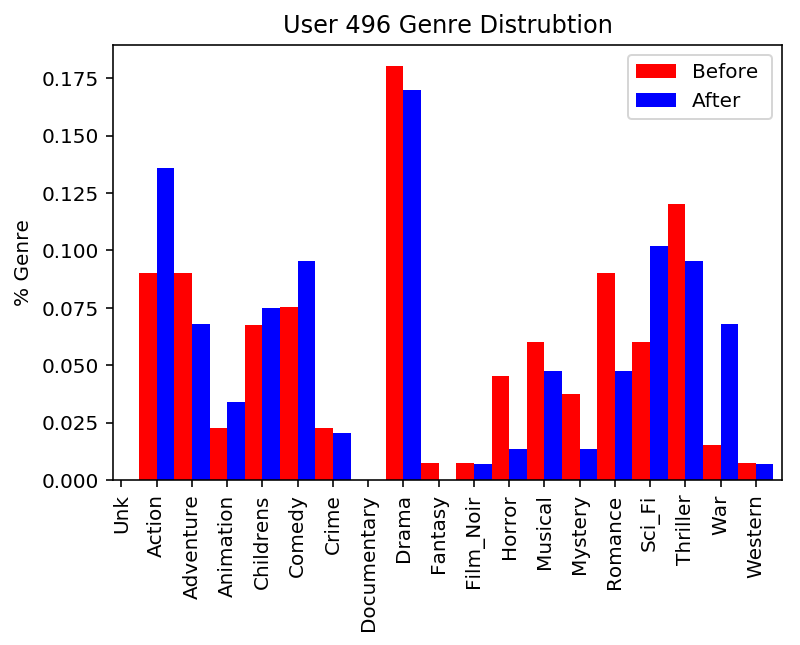

In [11]:
print("users in test set: ", lowest_cosim_ids)
user = lowest_cosim_ids[1]
movies_rec = user_history[user]['item_ids']
movie_set1 = movies_rec[0:60]
movie_set2 = movies_rec[61:121]

genre_matrix1 = movie_genres(movie_set1)
genre_matrix2 = movie_genres(movie_set2)
dist1 = genre_distribution(genre_matrix1)
dist2 = genre_distribution(genre_matrix2)
similarity = cosine_similarity(np.array(dist1).reshape(1,-1), np.array(dist2).reshape(1,-1))[0][0]

print("\nPrevious 60 Movie Genre Distribution \n", dist1)
print()
print("\nNext 60 Movie Genre Distribution \n", dist2)
print()
print("\n% Chnge per Genre \n", dist1-dist2)
print(similarity)

plot_histogram(user, dist1, dist2)

In [ ]:
plt.bar([dist1, dist2], label=['dist1', 'dist2'])
plt.legend(loc='upper right')
plt.show()

In [12]:
def moving_average(x):
    avgs = []
    for i, v in enumerate(x):
        avgs.append(np.sum(x[:i]) / i)
    return avgs

In [13]:
ses

[42.94473745255543,
 0.68371295478535543,
 38.496300331157855,
 12.66242907252292,
 15.026269984317789,
 0.0021257229490708272,
 3.6002607579474661,
 0.26521368369904114,
 13.675224136554766,
 27.246608348032602,
 1.1108091263103927,
 0.23666822253826603,
 1.0821758945313387,
 16.687165734352316,
 1.3658708592705131,
 20.782084210953563,
 2.7290856054997374,
 0.65009440086584436,
 0.68260219989057513,
 1.7209048084290943,
 1.7478673719599105,
 3.200712589972714,
 4.4375080007304515,
 10.434392363791117,
 3.8581502240516614,
 3.6002790312627666,
 0.034751665994281769,
 8.7412775808411212,
 0.4642962674408424,
 1.5602551474783268,
 12.819485405047619,
 0.01663579696581366,
 2.5606139297096644,
 16.078416511176183,
 38.45427033705122,
 0.086325307729429368,
 0.96309018993865314,
 1.2312393772726284,
 4.7891292263770486,
 5.9315567358333894,
 0.51213764461453903,
 2.7265749375995694,
 7.1639749052444612,
 6.4865285587528341,
 0.032326862843157,
 0.85661079360318848,
 2.3097818281752862,
 2

In [ ]:
mses = moving_average(test_ses)
print(mses[-1])

/Users/bsrikishan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


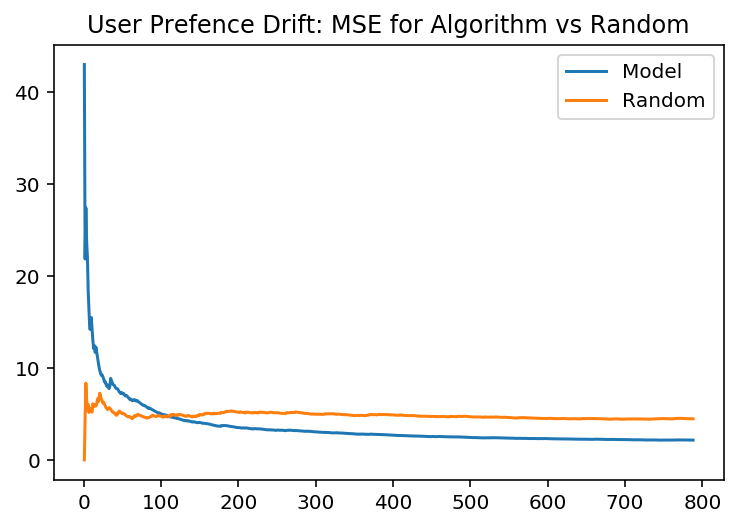

In [15]:
mses = moving_average(ses)
random_mses = moving_average(random_ses)
plt.plot(range(len(mses)), mses, label='Model')
plt.plot(range(len(random_mses)), random_mses, label='Random')
plt.legend()
plt.title("User Prefence Drift: MSE for Algorithm vs Random")
plt.savefig("drift_MSE.png", bbox_inches='tight')
plt.show()

In [ ]:
plt.scatter(range(len(ctr_hist)), ctr_hist)
plt.title("cumulative take rate {:.2f}".format(ctr_hist[-1]))
plt.show()